In [34]:
#importing packages
from tqdm import tqdm 
from math import sqrt
%matplotlib inline
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import warnings
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [35]:
#reading dataset
train_df = pd.read_csv("./train.csv")
validation_df = pd.read_csv('./validation.csv')
test_df = pd.read_csv('./test.csv')

In [36]:
#converting date format for easy visualization
train_df['Date'] = pd.to_datetime(train_df['Date'],format='%m/%d/%Y')
train_df = train_df.set_index('Date')
train_df.head()

validation_df['Date'] = pd.to_datetime(validation_df['Date'],format='%m/%d/%Y')
validation_df = validation_df.set_index('Date')
validation_df.head()

test_df['Date'] = pd.to_datetime(test_df['Date'],format='%m/%d/%Y')
test_df = test_df.set_index('Date')
test_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,46.876,46.936,45.741,45.904,6709362
2017-01-04,46.232,47.029,45.954,46.301,5750132
2017-01-05,46.122,46.528,45.220,45.507,6292690
2017-01-06,45.458,46.321,45.081,45.815,7071325
2017-01-09,45.616,46.936,45.389,46.678,4554264


In [103]:
#creating dataframe for high to use in generating features
train_df_high  = train_df[['High']]
validation_df_high  = validation_df[['High']]
test_df_high  = test_df[['High']]

# a) Statistics

No. of samples in Training dataset  : 519 

No. of samples in Validation dataset  : 252 

No. of samples in test dataset  : 218 



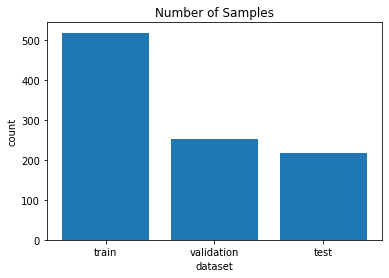

In [38]:
#NUMBER OF SAMPLES

train_samples = train_df['Volume'].count()
val_samples = validation_df['Volume'].count()
test_samples = test_df['Volume'].count()

print("No. of samples in Training dataset  :", train_samples, "\n")
print("No. of samples in Validation dataset  :", val_samples, "\n")
print("No. of samples in test dataset  :", test_samples, "\n")

label = ['train','validation','test']
samples = [train_samples, val_samples, test_samples]

plt.bar(label, samples)
plt.title('Number of Samples')
plt.xlabel('dataset')
plt.ylabel('count')
plt.show()

In [81]:
#TRAINING DATA STATS
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=train_df.index,y=train_df['Open'],name='Opening Price'),secondary_y=False)
fig2.add_trace(go.Scatter(x=train_df.index,y=train_df['Close'],name='Closing Price'),secondary_y=False)
fig2.add_trace(go.Bar(x=train_df.index,y=train_df['Volume'],name='Volume'),secondary_y=True)
fig2.update_layout(title="Training Data Statistics (Open vs Close with Volume)")
fig2.update_yaxes(range=[0,200000000],secondary_y=True)
fig2.show()

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=train_df.index,y=train_df['Low'],name='Lowest Price'),secondary_y=False)
fig2.add_trace(go.Scatter(x=train_df.index,y=train_df['High'],name='Highest Price'),secondary_y=False)
fig2.update_layout(title="Training Data Statistics (Low vs High i.e range")
fig2.update_yaxes(range=[0,200000000],secondary_y=True)
fig2.show()

In [82]:

#VALIDATION DATA STATS
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=validation_df.index,y=validation_df['Open'],name='Opening Price'),secondary_y=False)
fig2.add_trace(go.Scatter(x=validation_df.index,y=validation_df['Close'],name='Closing Price'),secondary_y=False)
fig2.add_trace(go.Bar(x=validation_df.index,y=validation_df['Volume'],name='Volume'),secondary_y=True)
fig2.update_layout(title="Validation Data Statistics (Open vs Close with Volume)")
fig2.update_yaxes(range=[0,200000000],secondary_y=True)
fig2.show()

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=validation_df.index,y=validation_df['Low'],name='Lowest Price'),secondary_y=False)
fig2.add_trace(go.Scatter(x=validation_df.index,y=validation_df['High'],name='Highest Price'),secondary_y=False)
fig2.update_layout(title="Validation Data Statistics (Low vs High i.e range")
fig2.update_yaxes(range=[0,200000000],secondary_y=True)
fig2.show()


In [83]:

#TESTING DATA STATS
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=test_df.index,y=test_df['Open'],name='Opening Price'),secondary_y=False)
fig2.add_trace(go.Scatter(x=test_df.index,y=test_df['Close'],name='Closing Price'),secondary_y=False)
fig2.add_trace(go.Bar(x=test_df.index,y=test_df['Volume'],name='Volume'),secondary_y=True)
fig2.update_layout(title="Testing Data Statistics (Open vs Close with Volume)")
fig2.update_yaxes(range=[0,200000000],secondary_y=True)
fig2.show()

fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Scatter(x=test_df.index,y=test_df['Low'],name='Lowest Price'),secondary_y=False)
fig2.add_trace(go.Scatter(x=test_df.index,y=test_df['High'],name='Highest Price'),secondary_y=False)
fig2.update_layout(title="Testing Data Statistics (Low vs High i.e range")
fig2.update_yaxes(range=[0,200000000],secondary_y=True)
fig2.show()


In [ ]:
# Read data
# Create Feautre embeddings, X and Y for each dataset by converting df to array
# Creating tensors from those arrays using torch.

# Can use the tensors directly, if you are able to load them completely (good for small datasets)
# The torch.util.data.Dataset is an abstraction to be able to load and process each sample of your dataset lazily
# torch.util.data.DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc.


In [127]:
# Getting Features embeddings from data and subsequent x and y for each dataset
look_back=11

#training
arr_data_train = train_df_high.to_numpy()
data_train =[]
for index in range(len(train_df_high)-look_back):
    data_train.append(arr_data_train[index:index+look_back])
#converting dataframe to array
data_train = np.array(data_train)
X_train = data_train[:,:-1,:]
Y_train = data_train[:,-1,:]

#validation
arr_data_validation = validation_df_highf.to_numpy()
data_validation =[]
for index in range(len(validation_df_high)-look_back):
    data_validation.append(arr_data_validation[index:index+look_back])
#converting dataframe to array
data_validation = np.array(data_validation)
X_validate = data_validation[:,:-1,:]
Y_validate = data_validation[:,-1,:]

#test
arr_data_test = test_df_high.to_numpy()
data_test =[]
for index in range(len(test_df_high)-look_back):
    data_test.append(arr_data_test[index:index+look_back])
#converting dataframe to array
data_test = np.array(data_test)
X_test = data_test[:,:-1,:]
Y_test = data_test[:,-1,:]

In [128]:
print(X_train)

[[[24.064]
  [25.139]
  [24.616]
  ...
  [25.265]
  [25.466]
  [25.324]]

 [[25.139]
  [24.616]
  [25.369]
  ...
  [25.466]
  [25.324]
  [25.389]]

 [[24.616]
  [25.369]
  [25.739]
  ...
  [25.324]
  [25.389]
  [25.275]]

 ...

 [[41.269]
  [40.954]
  [41.771]
  ...
  [42.059]
  [42.446]
  [42.956]]

 [[40.954]
  [41.771]
  [42.356]
  ...
  [42.446]
  [42.956]
  [42.386]]

 [[41.771]
  [42.356]
  [41.631]
  ...
  [42.956]
  [42.386]
  [42.652]]]


In [129]:
#creating tensors for training dataset
X_train = torch.from_numpy(X_train).type(torch.Tensor)
Y_train = torch.from_numpy(Y_train).type(torch.Tensor)

#creating tensors for validation dataset
X_validate = torch.from_numpy(X_validate).type(torch.Tensor)
Y_validate = torch.from_numpy(Y_validate).type(torch.Tensor)

#creating tensors for test dataset
X_test = torch.from_numpy(X_test).type(torch.Tensor)
Y_test = torch.from_numpy(Y_test).type(torch.Tensor)

In [130]:
print(X_train)

tensor([[[24.0640],
         [25.1390],
         [24.6160],
         ...,
         [25.2650],
         [25.4660],
         [25.3240]],

        [[25.1390],
         [24.6160],
         [25.3690],
         ...,
         [25.4660],
         [25.3240],
         [25.3890]],

        [[24.6160],
         [25.3690],
         [25.7390],
         ...,
         [25.3240],
         [25.3890],
         [25.2750]],

        ...,

        [[41.2690],
         [40.9540],
         [41.7710],
         ...,
         [42.0590],
         [42.4460],
         [42.9560]],

        [[40.9540],
         [41.7710],
         [42.3560],
         ...,
         [42.4460],
         [42.9560],
         [42.3860]],

        [[41.7710],
         [42.3560],
         [41.6310],
         ...,
         [42.9560],
         [42.3860],
         [42.6520]]])


In [131]:
#A tensor is a generalization of vectors and matrices to potentially higher dimensions
print(X_train.shape)

torch.Size([508, 10, 1])


In [132]:
# You can use the plain tensors as X_train and y_train, if you are able to load them completely (and push to the GPU without sacrificing too much memory).
# The Dataset is ab abstraction to be able to load and process each sample of your dataset lazily, while the DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc.
# That being said, you are of course fine to use the tensors directly, which might also be faster if you are using a tiny dataset.

batch_size = 60

#TRAINING DATA
train_dataset = torch.utils.data.TensorDataset(X_train,Y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
#VALIDATION DATA
validation_dataset = torch.utils.data.TensorDataset(X_validate,Y_validate)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
#TESTING DATA
test_dataset = torch.utils.data.TensorDataset(X_test,Y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [141]:
print(train_dataset[:])

(tensor([[[24.0640],
         [25.1390],
         [24.6160],
         ...,
         [25.2650],
         [25.4660],
         [25.3240]],

        [[25.1390],
         [24.6160],
         [25.3690],
         ...,
         [25.4660],
         [25.3240],
         [25.3890]],

        [[24.6160],
         [25.3690],
         [25.7390],
         ...,
         [25.3240],
         [25.3890],
         [25.2750]],

        ...,

        [[41.2690],
         [40.9540],
         [41.7710],
         ...,
         [42.0590],
         [42.4460],
         [42.9560]],

        [[40.9540],
         [41.7710],
         [42.3560],
         ...,
         [42.4460],
         [42.9560],
         [42.3860]],

        [[41.7710],
         [42.3560],
         [41.6310],
         ...,
         [42.9560],
         [42.3860],
         [42.6520]]]), tensor([[25.3890],
        [25.2750],
        [24.1230],
        [23.9670],
        [24.4220],
        [24.5300],
        [25.6730],
        [26.1430],
        [26.0300

In [144]:
print(train_loader)

### b) LSTM Model (n layers)

In [145]:
#creating base model LSTM
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,out_dim):
        super(LSTM,self).__init__()
        
        #Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        #Number of Hidden Layers
        self.num_layers = num_layers
        
        #Building LSTM using number of layers
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers, batch_first = True)
        #adding dropout of 2 nodes out of 10 to prevent overfitting
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, out_dim)
    
    def forward(self,x):
        #Initialize hidden state with zeros
        hidden_zeroes = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        # Initialize cell state
        cell_zeroes = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (hidden_zeroes.detach(), cell_zeroes.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [146]:
device = "cpu"
#torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [205]:
#customizing hyperparameters, taking MSE as loss and adam as optimizer.
def LSTM_model(model,num_epochs,train_dl,validation_dl):
    val_losses=[]
    train_losses=[]
    
    min_loss=float('inf')
    
    best_model = model
    
    learn_rate = 0.01
    
    #using MSE loss
    criterion = torch.nn.MSELoss(size_average=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    for epoch in range(num_epochs):
        
        #TRAINING (model.train mode)
        model.to(device)
        model.train()
        correct = 0
        total = 0
        num_batches = 0
        train_loss = 0.0
        
        for batch_idx, (feature_data,labels) in enumerate(train_dl):
            
            feature_data = feature_data.to(device)
            
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(feature_data)
            
            loss = criterion(output,labels)
            
            loss.backward()
            
            optimizer.step()
            
            total += labels.size(0)  
            
            train_loss += loss.item()
            
            num_batches+=1
        
        train_loss = train_loss/num_batches
        
        
        #VALIDATING (model.eval mode)
        model.to(device)
        model.eval()
        correct = 0
        total = 0
        num_batches = 0
        val_loss = 0.0
        
        for batch_idx,(feature_data,labels) in enumerate(validation_dl):
            
            feature_data = feature_data.to(device)
            
            labels = labels.to(device)
            
            output = model(feature_data)
            
            loss = criterion(output,labels)
            
            total += labels.size(0)
            
            val_loss += loss.item()
            
            num_batches+=1
        
        val_loss = val_loss/num_batches
        

        #PRINTING LOSS
        if ((epoch%20)==0):    
            print(f'\t [Epoch] : {epoch} | [Train Loss] : {train_loss:.3f} | [Validation loss] : {val_loss:.3f} \n')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
        #choosing best model
        if(min_loss>val_loss):
            best_model = copy.deepcopy(model)
            min_loss = val_loss

    

    X = range(num_epochs)
    #plotting graph wrt losses
    y = train_losses
    z = val_losses
    
    plt.plot(X,y,color='green')
    plt.plot(X,z,color='red')
    plt.legend(['Train Loss','Validation Loss'],loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Training and Validation Losses")
    
    return best_model, train_loss, val_loss

# c) 1 hidden layer with 64 neurons

In [206]:
input_dim = 1 
hidden_dim = 64
num_layers = 1
output_dim = 1
model= LSTM(input_dim=input_dim, hidden_dim=hidden_dim,out_dim=output_dim, num_layers=num_layers)

	 [Epoch] : 0 | [Train Loss] : 1528.164 | [Validation loss] : 1212.687 

	 [Epoch] : 20 | [Train Loss] : 33.709 | [Validation loss] : 37.019 

	 [Epoch] : 40 | [Train Loss] : 30.209 | [Validation loss] : 31.445 

	 [Epoch] : 60 | [Train Loss] : 7.932 | [Validation loss] : 3.723 

	 [Epoch] : 80 | [Train Loss] : 1.512 | [Validation loss] : 0.840 

	 [Epoch] : 100 | [Train Loss] : 1.220 | [Validation loss] : 0.804 

	 [Epoch] : 120 | [Train Loss] : 4.669 | [Validation loss] : 5.854 

	 [Epoch] : 140 | [Train Loss] : 1.040 | [Validation loss] : 0.726 

	 [Epoch] : 160 | [Train Loss] : 1.029 | [Validation loss] : 0.751 

	 [Epoch] : 180 | [Train Loss] : 1.097 | [Validation loss] : 0.657 

	 [Epoch] : 200 | [Train Loss] : 0.993 | [Validation loss] : 0.791 

	 [Epoch] : 220 | [Train Loss] : 1.079 | [Validation loss] : 0.836 

	 [Epoch] : 240 | [Train Loss] : 1.075 | [Validation loss] : 0.550 



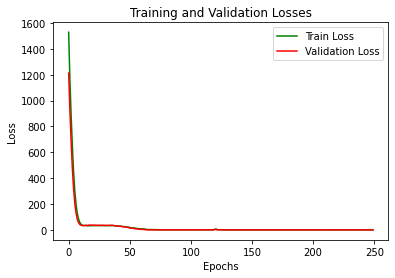

In [207]:
num_epochs = 250
best_model, train_loss, val_loss = LSTM_model(model,num_epochs,train_loader,validation_loader)

In [208]:
#T (model.eval mode)
model.to(device)
model.eval()
correct = 0
total = 0
num_batches = 0
test_loss = 0.0

# criterion = torch.nn.MSELoss(size_average=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
        
for batch_idx,(feature_data,labels) in enumerate(test_loader):
            
    feature_data = feature_data.to(device)
            
    labels = labels.to(device)
            
    output = best_model(feature_data)
            
    loss = criterion(output,labels)
            
    total += labels.size(0)
            
    test_loss += loss.item()
            
    num_batches+=1
        
test_loss = test_loss/num_batches
        
print("Test loss: ", "{:.2f}".format(test_loss))

Test loss:  0.86


In [209]:
print("Model with one hidden layers of 64 neurons\n")
print(f'\t [Train Error] : {train_loss:.3f} \n')
print(f'\t [Val Error] : {val_loss:.3f} \n')
print(f'\t [Test Error] : {test_loss:.3f} \n')

Model with one hidden layers of 64 neurons

	 [Train Error] : 0.969 

	 [Val Error] : 0.655 

	 [Test Error] : 0.864 



### d) 2 hidden layer with 64 neurons

In [211]:
input_dim = 1 
hidden_dim = 64
num_layers = 2
output_dim = 1
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,out_dim=output_dim, num_layers=num_layers)


	 [Epoch] : 0 | [Train Loss] : 1407.801 | [Validation loss] : 1040.152 

	 [Epoch] : 20 | [Train Loss] : 33.610 | [Validation loss] : 36.540 

	 [Epoch] : 40 | [Train Loss] : 33.743 | [Validation loss] : 36.623 

	 [Epoch] : 60 | [Train Loss] : 33.837 | [Validation loss] : 36.672 

	 [Epoch] : 80 | [Train Loss] : 33.907 | [Validation loss] : 36.710 

	 [Epoch] : 100 | [Train Loss] : 33.962 | [Validation loss] : 36.739 

	 [Epoch] : 120 | [Train Loss] : 34.005 | [Validation loss] : 36.762 

	 [Epoch] : 140 | [Train Loss] : 34.039 | [Validation loss] : 36.781 

	 [Epoch] : 160 | [Train Loss] : 34.067 | [Validation loss] : 36.796 

	 [Epoch] : 180 | [Train Loss] : 34.090 | [Validation loss] : 36.808 

	 [Epoch] : 200 | [Train Loss] : 34.109 | [Validation loss] : 36.818 

	 [Epoch] : 220 | [Train Loss] : 34.124 | [Validation loss] : 36.827 

	 [Epoch] : 240 | [Train Loss] : 34.136 | [Validation loss] : 36.833 



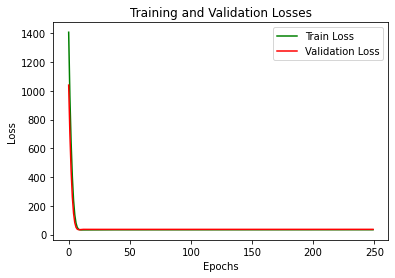

In [212]:
num_epochs = 250
best_model, train_loss, val_loss = LSTM_model(model,num_epochs,train_loader,validation_loader)

In [213]:
#T (model.eval mode)
model.to(device)
model.eval()
correct = 0
total = 0
num_batches = 0
test_loss = 0.0

# criterion = torch.nn.MSELoss(size_average=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
        
for batch_idx,(feature_data,labels) in enumerate(test_loader):
            
    feature_data = feature_data.to(device)
            
    labels = labels.to(device)
            
    output = best_model(feature_data)
            
    loss = criterion(output,labels)
            
    total += labels.size(0)
            
    test_loss += loss.item()
            
    num_batches+=1
        
test_loss = test_loss/num_batches
        
print("Test loss: ", "{:.2f}".format(test_loss))

Test loss:  81.72


In [214]:
print("Model with 2 hidden layers of 64 neurons\n")
print(f'\t [Train Error] : {train_loss:.3f} \n')
print(f'\t [Val Error] : {val_loss:.3f} \n')
print(f'\t [Test Error] : {test_loss:.3f} \n')

Model with 2 hidden layers of 64 neurons

	 [Train Error] : 34.141 

	 [Val Error] : 36.836 

	 [Test Error] : 81.719 



### e) Comparison

With increase in number of hidden layers, we see more time taken in training however there is no significant increase in accuracy, in fact the loss has increased.